In [1]:
!pip install newspaper3k
!pip install pandas
!pip install matplotlib
!pip install transformers
!pip install nltk
!pip install sentencepiece
!pip install ipywidgets
# using nvidia-docker image from https://ngc.nvidia.com/catalog/containers/nvidia:tensorflow/tags
# using release 21.02-tf2-py3

     |████████████████████████████████| 211 kB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 5.4 MB 3.4 MB/s eta 0:00:01
     |████████████████████████████████| 115 kB 6.3 MB/s eta 0:00:01
     |████████████████████████████████| 87 kB 6.9 MB/s  eta 0:00:01
     |████████████████████████████████| 2.2 MB 4.1 MB/s eta 0:00:01
     |████████████████████████████████| 7.4 MB 3.3 MB/s eta 0:00:01
     |████████████████████████████████| 80 kB 3.7 MB/s eta 0:00:01
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13537 sha256=f29940e580f6d5371e8b4014870bdf94d9449731438036bbac146ec9ef8369df
  Stored in directory: /root/.cache/pip/wheels/99/74/83/8fac1c8d9c648cfabebbbffe97a889f6624817f3aa0bbe6c09
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3354 sha256=a10a4dfbd150cd9da2589fff8f209bc4ffb7faacb3401b455a12b252a5f6a0c0
  Stored in directory: /root/.cache/pip/wheels/b6/09/68/a9f15498ac02c23dde29f18745bc6a6f574ba4ab4

In [1]:
import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
from time import time
import io
import re

import pickle
from csv import reader
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import layers
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten
# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

from datetime import datetime
from collections import defaultdict




In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# from transformers import BertTokenizer, TFBertModel

In [5]:
from transformers import TFT5ForConditionalGeneration, T5Tokenizer, AutoTokenizer

# Data Exploration

In [6]:
data = pd.read_table("biaseddata.csv", sep='\t', index_col=0)
# data = pd.read_table("processedbiasdata.csv", sep='\t', index_col=0)
data

,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,democrat.bias,republican.bias,isbiased,biascategories,biasmagnitude,biasprob
0,http://www.usatoday.com/story/news/nation/2013...,other,1,Civil Rights,Civil Rights,Neutral,Neutral,Maggie Clark Pew Stateline Staff Writer 21 s...,702,0.0,0.0,0,0,0.0,0.50
1,http://www.huffingtonpost.com/2013/05/21/senat...,News,0,Civil Rights,Civil Rights,Neutral,Neutral,WASHINGTON -- The Senate Judiciary Committee a...,1118,0.0,0.0,0,0,0.0,0.50
2,http://www.washingtonpost.com/opinions/dont-le...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,David Cole is a professor of constitutional la...,1401,0.0,0.0,0,0,0.0,0.50
3,http://www.foxnews.com/politics/2013/04/03/oba...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,"Parts of ObamaCare are starting to fray, even ...",798,0.0,0.0,0,0,0.0,0.50
4,http://www.breitbart.com/Big-Government/2013/1...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,U.S. Immigration Citizenship and Immigration S...,947,0.0,0.0,0,0,0.0,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16584,http://www.washingtonpost.com/opinions/dana-mi...,News,1,Republican Scandals,Republican Scandals,SomewhatPositive,SomewhatNegative,President Obama won reelection in part by beat...,768,0.5,-0.5,1,1,1.0,0.75
16585,http://news.yahoo.com/republicans-hatred-obama...,Opinion,1,Republican Scandals,Republican Scandals,SomewhatPositive,SomewhatNegative,"Red-faced Republicans, circling and preparing ...",805,0.5,-0.5,1,1,1.0,0.75
16586,http://www.washingtonpost.com/opinions/dana-mi...,News,1,Republican Scandals,Republican Scandals,Neutral,Neutral,Rep. Steve Stockman’s moment as a viable Senat...,896,0.0,0.0,0,0,0.0,0.50
16587,http://www.washingtonpost.com/opinions/ej-dion...,News,1,Republican Scandals,Republican Scandals,SomewhatPositive,SomewhatNegative,We interrupt this highly partisan and ideologi...,751,0.5,-0.5,1,1,1.0,0.75


In [7]:
data.shape

(13193, 15)

# T5 Testing

In [8]:
t5_model = 't5-small'

t5_tokenizer = T5Tokenizer.from_pretrained(t5_model)
model = TFT5ForConditionalGeneration.from_pretrained(t5_model)

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [9]:
sample_text = data.article[1]
encoding = t5_tokenizer.encode("""summarize: """ + sample_text, return_tensors='tf', max_length=1000)


outputs = model.generate(encoding,
                      num_beams=4, 
                      no_repeat_ngram_size=2,
                      min_length=100,
                      max_length=1000,
                      early_stopping=True)

summarization = t5_tokenizer.decode(outputs[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [10]:
summarization

'<pad> the gang of eight immigration bill passed in a 13 to 5 vote on monday. the bill will now go to the Senate floor, but all Democrats voted in favor of it, sen. john cornyn said if it had been between his vote and moving it forward, it would have been on the floor of the senator\'s committee he would support it. "the dysfunction in our current immigration system affects all of us and it is long past time for reform," Judiciary Chairman Patrick Leah'

In [11]:
sample_text

'WASHINGTON -- The Senate Judiciary Committee approved the bipartisan "gang of eight" immigration bill on Tuesday in a 13 to 5 vote after a marathon final day of markup that stretched into the evening.  All Democrats on the committee, along with Sen. Orrin Hatch (R-Utah) and gang of eight Republican Sens. Lindsey Graham (R-S.C.) and Jeff Flake (R-Ariz.), voted in favor of the bill, which will now go to the Senate floor. Sen. John Cornyn (R-Texas), who voted against the bill out of committee, said he would support allowing it to move forward for debate -- rather than joining a filibuster -- once on the Senate floor. Sen. Chuck Grassley (R-Iowa), who was also a "no" vote, said if it had been between his vote and moving the bill to the Senate floor, he would have voted in favor.  The crowd in the room erupted into applause when the final vote tally was read, rising to their feet and chanting "Yes we can!" then "Si se puede!"  Democrats seemed equally pleased to vote the bill out of commit

# T5 Gan Model

In [12]:
data = data.reset_index(drop=True)

In [13]:
data

,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,democrat.bias,republican.bias,isbiased,biascategories,biasmagnitude,biasprob
0,http://www.usatoday.com/story/news/nation/2013...,other,1,Civil Rights,Civil Rights,Neutral,Neutral,Maggie Clark Pew Stateline Staff Writer 21 s...,702,0.0,0.0,0,0,0.0,0.50
1,http://www.huffingtonpost.com/2013/05/21/senat...,News,0,Civil Rights,Civil Rights,Neutral,Neutral,WASHINGTON -- The Senate Judiciary Committee a...,1118,0.0,0.0,0,0,0.0,0.50
2,http://www.washingtonpost.com/opinions/dont-le...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,David Cole is a professor of constitutional la...,1401,0.0,0.0,0,0,0.0,0.50
3,http://www.foxnews.com/politics/2013/04/03/oba...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,"Parts of ObamaCare are starting to fray, even ...",798,0.0,0.0,0,0,0.0,0.50
4,http://www.breitbart.com/Big-Government/2013/1...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,U.S. Immigration Citizenship and Immigration S...,947,0.0,0.0,0,0,0.0,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13188,http://www.washingtonpost.com/opinions/dana-mi...,News,1,Republican Scandals,Republican Scandals,SomewhatPositive,SomewhatNegative,President Obama won reelection in part by beat...,768,0.5,-0.5,1,1,1.0,0.75
13189,http://news.yahoo.com/republicans-hatred-obama...,Opinion,1,Republican Scandals,Republican Scandals,SomewhatPositive,SomewhatNegative,"Red-faced Republicans, circling and preparing ...",805,0.5,-0.5,1,1,1.0,0.75
13190,http://www.washingtonpost.com/opinions/dana-mi...,News,1,Republican Scandals,Republican Scandals,Neutral,Neutral,Rep. Steve Stockman’s moment as a viable Senat...,896,0.0,0.0,0,0,0.0,0.50
13191,http://www.washingtonpost.com/opinions/ej-dion...,News,1,Republican Scandals,Republican Scandals,SomewhatPositive,SomewhatNegative,We interrupt this highly partisan and ideologi...,751,0.5,-0.5,1,1,1.0,0.75


In [14]:
# shuffle data
# data = data.sample(frac=1)
# data

In [15]:
tfdf = data[['article','isbiased']]
tfdf['text'] = data['article']
tfdf['label'] = data['isbiased']
tfdf = tfdf[['text','label']]
tfdf['label'] = tfdf['label'].replace(0, "unbiased")
tfdf['label'] = tfdf['label'].replace(1, "biased")
tfdf = tfdf.sample(frac=1)
tfdf = tfdf.reset_index(drop=True)

print(tfdf.shape)
tfdf.head()

(13193, 2)


<ipython-input-15-b0162bcf7b94>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tfdf['text'] = data['article']
<ipython-input-15-b0162bcf7b94>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tfdf['label'] = data['isbiased']


,text,label
0,On the rec list! Thank you all so much! Keep s...,biased
1,8 years ago (CNN) - For the first time in his...,unbiased
2,What I'm about to suggest works. I know it doe...,biased
3,"Gregory Korte, USA TODAY Incoming president s...",unbiased
4,Story highlights It has been two years since O...,unbiased


<AxesSubplot:>

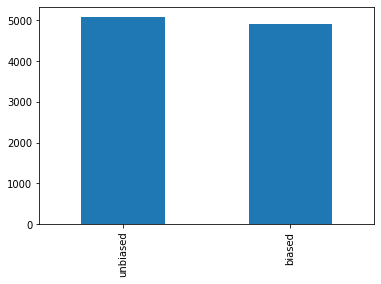

In [16]:
tfdf["label"][0:10000].value_counts().plot.bar()

<AxesSubplot:>

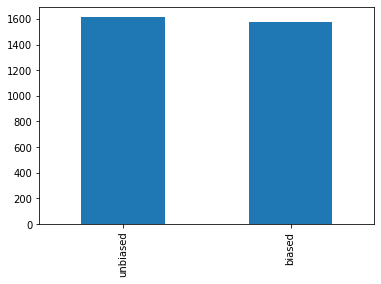

In [17]:
tfdf["label"][10000:].value_counts().plot.bar()

In [18]:
# plt.hist(data.length[0:10000], bins = 100)

In [19]:
train_data = tfdf[:10000].to_dict('records')
test_data = tfdf[10000:].to_dict('records')

In [16]:
# train_data[0]

In [17]:
# train_tfdata = tf.data.Dataset.from_tensor_slices(train_data[:3])
# # test_tfdata = tf.data.Dataset.from_tensor_slices(test_data)


In [18]:
# larget5_model = 't5-large'

# larget5_tokenizer = T5Tokenizer.from_pretrained(larget5_model)
# largemodel = TFT5ForConditionalGeneration.from_pretrained(larget5_model)


In [19]:
# data[data["isbiased"]==1]["article"][8]

In [62]:
warmup_steps = 1000
batch_size = 10
encoder_max_len = 2000

discriminator_max_len = 8 
generator_max_len = 1000
# generator_min_len = 500

buffer_size = 5000
ntrain = len(train_data)
nvalid = len(test_data)
steps = int(np.ceil(ntrain/batch_size))
valid_steps = int(np.ceil(nvalid/batch_size))
print("Total Steps: ", steps)
print("Total Validation Steps: ", valid_steps)

Total Steps:  1000
Total Validation Steps:  320


In [63]:
data_dir = "./data"
log_dir = f"{data_dir}/experiments/t5/logs"
save_path = f"{data_dir}/experiments/t5/models"
cache_path_train = f"{data_dir}/cache/t5.train"
cache_path_test = f"{data_dir}/cache/t5.test"

In [64]:
tokenizer = AutoTokenizer.from_pretrained("t5-small",  use_fast=False)

In [65]:
tfdf.head()

,text,label
0,On the rec list! Thank you all so much! Keep s...,biased
1,8 years ago (CNN) - For the first time in his...,unbiased
2,What I'm about to suggest works. I know it doe...,biased
3,"Gregory Korte, USA TODAY Incoming president s...",unbiased
4,Story highlights It has been two years since O...,unbiased


In [66]:
all(isinstance(x, str) for x in list(tfdf.text))

True

In [67]:
all(isinstance(x, str) for x in list(tfdf.label))

True

In [68]:
train_section = tfdf[:10000]
test_section = tfdf[10000:]
train_dataset =  tf.data.Dataset.from_tensor_slices((list(train_section['text']), list(train_section['label'])))
test_dataset =  tf.data.Dataset.from_tensor_slices((list(test_section['text']), list(test_section['label'])))
# train_section = tfdf[:10000].to_dict('records')
# test_section = tfdf[10000:].to_dict('records')
# train_section = tfdf[:10000].to_dict('list')
# test_section = tfdf[10000:].to_dict('list')

In [69]:
tfdf[:10000].shape[0]

10000

In [70]:
# def meta_dict_gen(d):
#     for i in range(d.shape[]):
#         ls = {}
#         for key, val in d.items():
#             ls[key] = val[i]
#         yield ls

In [71]:
# dataset = tf.data.Dataset.from_generator(
#     meta_dict_gen,
#     output_types={k: tf.float32 for k in metadata},
#     output_shapes={'m1': (2,), 'm2': (3, 5)})

In [72]:
# train_dataset =  tf.data.Dataset.from_tensor_slices((train_section))
# test_dataset =  tf.data.Dataset.from_tensor_slices((test_section))

In [73]:
data = next(iter(train_dataset))
data

(<tf.Tensor: shape=(), dtype=string, numpy=b'On the rec list! Thank you all so much! Keep spreading the word about Senator Begich\'s plan. He has the right idea about what to do to strengthen Social Security and we need to get Democrats to make this the party\'s official plan. Expect more diaries about Begich from me.  Ok, so far Laurence Lewis\' front page post is about Chuck Hagel and John Brennan, which yes highlights some valid points and the rec list has diaries about Obama wanting to cut Social Security. Great way to start Sunday Morning off with the first big Obama Rocks Obama Sucks Pie Fight. Well since the rec list gets filled with both "Obama Will Betray Us" and "11th Dimensional Chess" themed diaries, I for one am going to repeat a call for action that I have made several times but only made the rec list once. And that is to get everyone to get their Senator and Congressman to back Senator Mark Begich\'s (D. AK) plan to strengthen Social Security. I\'ve already written about

In [74]:
train_dataset

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.string)>

In [ ]:
c = 0

In [ ]:
def encode(context, label, encoder_max_len=encoder_max_len, 
           gen_decoder_max_len=generator_max_len, dis_decoder_max_len = discriminator_max_len):
#     print(context)
#     print(label)
    global c
    c+=1
    print(c)
#     print("context: "+context)
#     print("label: "+label)
    context_plus = f"context:  {str(context.numpy().decode('utf-8'))} </s>"
    text_plus = f"paraphrase:   {str(context.numpy().decode('utf-8'))} </s>"
    label_plus = f"label:   {str(context.numpy().decode('utf-8'))} </s>"

    encoder_inputs = tokenizer(context_plus, truncation=True, 
                               return_tensors='tf', max_length=encoder_max_len,
                              padding=True)
    
    gener_decoder_inputs = tokenizer(text_plus, truncation=True, 
                               return_tensors='tf', max_length=gen_decoder_max_len,
                              padding=True)
    
    discr_decoder_inputs = tokenizer(label_plus, truncation=True, 
                               return_tensors='tf', max_length=dis_decoder_max_len,
                              padding=True)
    
    input_ids = encoder_inputs['input_ids'][0]
    input_attention = encoder_inputs['attention_mask'][0]
    
    gener_target_ids = gener_decoder_inputs['input_ids'][0]
    gener_target_attention = gener_decoder_inputs['attention_mask'][0]
    
    discr_target_ids = discr_decoder_inputs['input_ids'][0]
    discr_target_attention = discr_decoder_inputs['attention_mask'][0]

    return input_ids, input_attention, gener_target_ids, gener_target_attention, discr_target_ids, discr_target_attention
#     outputs = {'input_ids':input_ids, 'attention_mask': input_attention, 
#                'generator_ids':gener_target_ids, 'generator_attention_mask':gener_target_attention,
#                'discriminator_ids':discr_target_ids, 'discriminator_attention_mask':discr_target_attention}
# #     return input_ids,input_attention, gener_target_ids, gener_target_attention, discr_target_ids, discr_target_attention
#     return outputs

In [ ]:
# def encode_tf(inputs):
def encode_tf(text, label):
#     context = inputs['context']
#     question = inputs['question']
#     answer = inputs['answers']['text']
    encoded = tf.py_function(encode, [text, label], 
                                           [tf.int32, tf.int32, tf.int32, tf.int32,tf.int32, tf.int32])
    input_ids,input_attention, generator_ids, generator_attention, discriminator_ids, discriminator_attention = encoded
    
    input_ids.set_shape([None])
    generator_ids.set_shape([None])
    discriminator_ids.set_shape([None])
    
    input_attention.set_shape([None])
    generator_attention.set_shape([None])
    discriminator_attention.set_shape([None])
    
#     labels = tf.reshape(target_ids, [-1, 1])
    data=  {'input_ids': input_ids, #'decoder_input_ids': target_ids, 
            'generator_ids': generator_ids,
            'discriminator_ids': discriminator_ids,
            'input_attention_mask': input_attention,
            'generator_attention_mask': generator_attention,
           'discriminator_attention_mask': discriminator_attention}
    return (data, None)


In [ ]:
def create_dataset(source_dataset, cache_path=None, batch_size=4, 
                   buffer_size= 1000, shuffling=True):
#     dataset = source_dataset.map(encode_tf, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = source_dataset.map(encode_tf, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    if cache_path is not None:
        dataset = dataset.cache(cache_path)        
    if shuffling:
        dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset
    

In [ ]:
type(train_data)

In [ ]:
train_tf = train_dataset.map(encode_tf, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
train_tf = train_tf.shuffle(buffer_size)

In [ ]:
train_tf = train_tf.batch(batch_size)

In [ ]:
train_tf = train_tf.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
data = next(iter(train_tf))
data

In [ ]:
train_ds= create_dataset(train_dataset, batch_size=batch_size, 
                         shuffling=True, cache_path = None)
test_ds = create_dataset(test_dataset, batch_size=batch_size, 
                         shuffling=False, cache_path = None)
# https://stackoverflow.com/questions/49531286/tensorflow-tf-data-dataset-cannot-batch-tensors-with-different-shapes-in-compo

In [ ]:
type(train_ds)

In [82]:
data = next(iter(train_ds))
data

1
2
3
4
5
6
7
8
9
10
11
12
13


/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5.py:174: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


14
15
16
17
18
19
2021
22

23
24
25
26
27
2829

30
31
32
33
34
35
36
37
38
39
40
41
42
4344

45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
7980
81
82
83

8485

86
87
88
89
90
91
92
93
94
95
96
97
98
99100

101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137138
139
140
141
142

143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
28

InvalidArgumentError: Cannot batch tensors with different shapes in component 2. First element had shape [991] and element 1 had shape [745].

In [ ]:
# train_ds = [encode(i) for i in train_data]
# test_ds = [encode(i) for i in test_data]

In [ ]:
# train_tfdataset = tf.data.Dataset.from_tensor_slices(train_ds[:5])


In [ ]:
# tokenizer.decode(train_ds[0]['input_ids'])

In [ ]:
# def create_dataset(source_dataset, cache_path=None, batch_size=4, 
#                    buffer_size= 1000, shuffling=True):
#     dataset = source_dataset.map(encode_tf, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
#     if cache_path is not None:
#         dataset = dataset.cache(cache_path)        
#     if shuffling:
#         dataset = dataset.shuffle(buffer_size)
#     dataset = dataset.batch(batch_size)
#     dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
#     return dataset

In [ ]:

# def to_tf_dataset(dataset):  
#   columns = ['input_ids', 'attention_mask', 'labels', 'decoder_attention_mask']
#   dataset.set_format(type='tensorflow', columns=columns)
#   return_types = {'input_ids':tf.int32, 'attention_mask':tf.int32, 
#                 'labels':tf.int32, 'decoder_attention_mask':tf.int32,  }
#   return_shapes = {'input_ids': tf.TensorShape([None]), 'attention_mask': tf.TensorShape([None]), 
#                   'labels': tf.TensorShape([None]), 'decoder_attention_mask':tf.TensorShape([None])}
#   ds = tf.data.Dataset.from_generator(lambda : dataset, return_types, return_shapes)
#   return ds

In [ ]:
def to_tf_dataset(dataset):  
    columns = ['input_ids', 'attention_mask', 'generator_ids', 'generator_attention_mask','discriminator_ids','discriminator_attention_mask']
    dataset.set_format(type='tensorflow', columns=columns)
    return_types = {'input_ids':tf.int32, 'attention_mask':tf.int32, 
                'generator_ids':tf.int32, 'generator_attention_mask':tf.int32,
                   'discriminator_ids':tf.int32, 'discriminator_attention_mask':tf.int32,  }
    
    return_shapes = {'input_ids': tf.TensorShape([None]), 'attention_mask': tf.TensorShape([None]), 
                  'generator_ids': tf.TensorShape([None]), 'generator_attention_mask':tf.TensorShape([None]),
                    'discriminator_ids': tf.TensorShape([None]), 'discriminator_attention_mask':tf.TensorShape([None]),}
    
    ds = tf.data.Dataset.from_generator(lambda : dataset, return_types, return_shapes)
    return ds

In [ ]:
tf_train_ds = to_tf_dataset(train_ds)
tf_test_ds = to_tf_dataset(test_ds)

In [ ]:

sample_text = data.article[8]
encoding = larget5_tokenizer.encode("""summarize: """ + sample_text, return_tensors='tf', max_length=1000)


outputs = largemodel.generate(encoding,
                      num_beams=4, 
                      no_repeat_ngram_size=2,
                      min_length=500,
                      max_length=1000,
                      early_stopping=True)

summarization = larget5_tokenizer.decode(outputs[0])

In [ ]:

sample_text = data.article[8]
encoding = larget5_tokenizer.encode("""summarize: """ + sample_text, return_tensors='tf', max_length=1000)


outputs = largemodel.generate(encoding,
                      num_beams=4, 
                      no_repeat_ngram_size=2,
                      min_length=500,
                      max_length=1000,
                      early_stopping=True)

summarization = larget5_tokenizer.decode(outputs[0])

In [ ]:
summarization

In [ ]:
# data processing


# task = "summarize: "
task = "paraphrase: "

t5_train_text = [task+i for i in train_text]
t5_test_text = [task+ i for i in test_text]

In [ ]:
# from T5 notebook

In [ ]:
class discriminatortT5(TFT5ForConditionalGeneration):
    def __init__(self, *args, log_dir=None, cache_dir= None, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_tracker= tf.keras.metrics.Mean(name='loss') 
    
    @tf.function
    def train_step(self, data):
        x = data
        y = x["labels"]
        y = tf.reshape(y, [-1, 1])
        with tf.GradientTape() as tape:
            outputs = self(x, training=True)
            loss = outputs[0]
            logits = outputs[1]
            loss = tf.reduce_mean(loss)
            
            grads = tape.gradient(loss, self.trainable_variables)
            
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        lr = self.optimizer._decayed_lr(tf.float32)
        
        self.loss_tracker.update_state(loss)        
        self.compiled_metrics.update_state(y, logits)
        metrics = {m.name: m.result() for m in self.metrics}
        metrics.update({'lr': lr})
        
        return metrics

    def test_step(self, data):
        x = data
        y = x["labels"]
        y = tf.reshape(y, [-1, 1])
        output = self(x, training=False)
        loss = output[0]
        loss = tf.reduce_mean(loss)
        logits = output[1]
        
        self.loss_tracker.update_state(loss)
        self.compiled_metrics.update_state(y, logits)
        return {m.name: m.result() for m in self.metrics}

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("t5-base")          

In [ ]:
warmup_steps = 1e4
batch_size = 4
encoder_max_len = 250
decoder_max_len = 54
buffer_size = 1000
ntrain = len(train_dataset)
nvalid = len(valid_dataset)
steps = int(np.ceil(ntrain/batch_size))
valid_steps = int(np.ceil(nvalid/batch_size))
print("Total Steps: ", steps)
print("Total Validation Steps: ", valid_steps)

In [ ]:
def encode(example,
           encoder_max_len=encoder_max_len, decoder_max_len=decoder_max_len):
  
    context = example['context']
    question = example['question']
    answer = example['answers']['text']
  
    question_plus = f"answer_me: {str(question)}"
    question_plus += f" context: {str(context)} </s>"
    
    answer_plus = ', '.join([i for i in list(answer)])
    answer_plus = f"{answer_plus} </s>"
    
    encoder_inputs = tokenizer(question_plus, truncation=True, 
                               return_tensors='tf', max_length=encoder_max_len,
                              pad_to_max_length=True)
    
    decoder_inputs = tokenizer(answer_plus, truncation=True, 
                               return_tensors='tf', max_length=decoder_max_len,
                              pad_to_max_length=True)
    
    input_ids = encoder_inputs['input_ids'][0]
    input_attention = encoder_inputs['attention_mask'][0]
    target_ids = decoder_inputs['input_ids'][0]
    target_attention = decoder_inputs['attention_mask'][0]
    
    outputs = {'input_ids':input_ids, 'attention_mask': input_attention, 
               'labels':target_ids, 'decoder_attention_mask':target_attention}
    return outputs
    
    

In [ ]:
train_ds=  train_dataset.map(encode)
valid_ds=  valid_dataset.map(encode)

In [ ]:
# Text generation model




def t5_keras_model():
    
    
    encode_in = tf.keras.layers.Input(shape=(max_len,), dtype='int32', name="encode_in_ids")
    enc_mask_in = tf.keras.layers.Input(shape=(max_len,), dtype='int32', name="enc_mask_in_ids")
    decode_in = tf.keras.layers.Input(shape=(None,), dtype='int32', name="decode_in_ids")
    dec_mask_in = tf.keras.layers.Input(shape=(None,), dtype='int32', name="dec_mask_in_ids")
    
    t5_layer = TFT5ForConditionalGeneration.from_pretrained(t5_model)
    
    t5_out = t5_layer({'input_ids': encode_in, 
                       'decoder_input_ids':decode_in, 
                       'attention_mask':enc_mask_in,
                       'decoder_attention_mask':dec_mask_in
                      }, 
                             return_dict=True)
    
    pred_logits = t5_out['logits']
    
    model = tf.keras.models.Model(inputs=[encode_in, 
                                          enc_mask_in, 
                                          decode_in,
                                          dec_mask_in
                                         ], 
                                  outputs=pred_logits)

    model.compile(loss=t5_custom_loss, 
                  optimizer=tf.keras.optimizers.Adam(), 
                  metrics=[
                  #     tf.keras.metrics.Accuracy(),
                          t5_custom_acc_orig_tokens, 
                           t5_custom_acc_orig_tokens_no_other,
                      t5_custom_acc_orig_tokens_begin_cont,
                      t5_custom_acc_orig_tokens_not_begin_cont_other
                  #
                  ]
                 )
    
    
    model.summary()
    
    return model




In [ ]:
BATCH_SIZE = 8

SHUFFEL_SIZE = 1024

learning_rate = 3e-5

model_size = "t5-small"


In [ ]:
tokenizer = T5Tokenizer.from_pretrained(model_size)

model = TFT5model.from_pretrained(model_size)

task_specific_params = model.config.task_specific_params
if task_specific_params is not None:
    model.config.update(task_specific_params.get("summarization", {}))

pad_token_id = tokenizer.pad_token_id

In [ ]:
task_specific_params = model.config.task_specific_params
if task_specific_params is not None:
    model.config.update(task_specific_params.get("summarization", {}))
    
pad_token_id = tokenizer.pad_token_id

In [ ]:
BATCH_SIZE = 4

SHUFFEL_SIZE = 512

learning_rate = 3e-5

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08, clipnorm=1.0)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

model.summary()